In [2]:
from keras.layers import *
from keras.models import Model
from keras import layers
from keras.layers.merge import concatenate
import sys
sys.path.insert(1, '../src')
sys.path.insert(1, '../image_segmentation_keras')
from keras_segmentation.models.config import IMAGE_ORDERING

from keras_segmentation.models.model_utils import get_segmentation_model
from glob import glob
from crfrnn_layer import CrfRnnLayer

Using TensorFlow backend.


In [3]:
input_height = 256
input_width = 256
n_classes = 3
channels = 3

In [4]:
def unet_conv_block(inputs, filters, pool=True, batch_norm_first=True):
    if batch_norm_first == True:
        x = Conv2D(filters, 3, padding="same")(inputs)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)

        x = Conv2D(filters, 3, padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
    elif batch_norm_first == False:
        x = Conv2D(filters, 3, padding="same")(inputs)
        x = Activation("relu")(x)
        x = BatchNormalization()(x)

        x = Conv2D(filters, 3, padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization()(x)

    if pool == True:
        p = MaxPooling2D((2, 2))(x)
        return [x, p]
    else:
        return x

In [5]:
img_input = Input(shape=(input_height,input_width, channels))
f1 = unet_conv_block(img_input, 64, pool=True, batch_norm_first=False)
f2 = unet_conv_block(f1[1], 128, pool=True, batch_norm_first=False)
f3 = unet_conv_block(f2[1], 256, pool=True, batch_norm_first=False)
f4 = unet_conv_block(f3[1], 512, pool=True, batch_norm_first=False)
f5 = unet_conv_block(f4[1], 1024, pool=False, batch_norm_first=False)

x = UpSampling2D((2, 2))(f5)
x = concatenate([x, f4[0]], axis=3)
x = unet_conv_block(x, 512, pool=False, batch_norm_first=False)

x = UpSampling2D((2, 2))(x)
x = concatenate([x, f3[0]], axis=3)
x = unet_conv_block(x, 256, pool=False, batch_norm_first=False)

x = UpSampling2D((2, 2))(x)
x = concatenate([x, f2[0]], axis=3)
x = unet_conv_block(x, 128, pool=False, batch_norm_first=False)

x = UpSampling2D((2, 2))(x)
x = concatenate([x, f1[0]], axis=3)
x = unet_conv_block(x, 64, pool=False, batch_norm_first=False)

x = Conv2D(n_classes, (1,1), padding='same')(x)
x = BatchNormalization()(x)
crf_output = CrfRnnLayer(image_dims=(input_height, input_width),
                         num_classes=n_classes,
                         theta_alpha=160.,
                         theta_beta=3.,
                         theta_gamma=3.,
                         num_iterations=10,
                         name='crfrnn')([x, img_input])
model = get_segmentation_model(img_input, crf_output)


In [6]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 256, 256, 64) 0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 256, 256, 64) 256         activation_1[0][0]               
____________________________________________________________________________________________

In [5]:
model.train(
    train_images =  "/Users/mavaylon/Research/Data1/train/img/",
    train_annotations = "/Users/mavaylon/Research/Data1/train/ann/",
    epochs=20,
    steps_per_epoch=len(glob("/Users/mavaylon/Research/Data1/train/img/*")),
    batch_size=1,
    validate=True,
    val_images="/Users/mavaylon/Research/Data1/test/img/",
    val_annotations="/Users/mavaylon/Research/Data1/test/ann/",
    val_batch_size=1,
    val_steps_per_epoch=len(glob("/Users/mavaylon/Research/Data1/test/img/*"))
)

Verifying training dataset


  0%|          | 0/1478 [00:00<?, ?it/s]

Dataset verified! 
Verifying validation dataset


100%|██████████| 1478/1478 [00:05<00:00, 284.49it/s]


Dataset verified! 
fit
Epoch 1/20
5912/5912 [==============================] - 22076s 4s/step - loss: 0.6143 - accuracy: 0.7604 - val_loss: 0.4441 - val_accuracy: 0.7766

Epoch 00001: val_accuracy improved from -inf to 0.77658, saving model to pet_class_crf.h5
Epoch 2/20
5912/5912 [==============================] - 24049s 4s/step - loss: 0.5072 - accuracy: 0.8094 - val_loss: 0.4189 - val_accuracy: 0.8088

Epoch 00002: val_accuracy improved from 0.77658 to 0.80881, saving model to pet_class_crf.h5
Epoch 3/20
5912/5912 [==============================] - 27165s 5s/step - loss: 0.4492 - accuracy: 0.8340 - val_loss: 0.4880 - val_accuracy: 0.8282

Epoch 00003: val_accuracy improved from 0.80881 to 0.82816, saving model to pet_class_crf.h5
Epoch 4/20
5912/5912 [==============================] - 23753s 4s/step - loss: 0.4064 - accuracy: 0.8518 - val_loss: 0.4069 - val_accuracy: 0.8263

Epoch 00004: val_accuracy did not improve from 0.82816
Epoch 5/20
5912/5912 [==============================] 

In [18]:
model.load_weights('/Users/mavaylon/Research/pet_weights/UNET_CRF_PET/pet_class_crf.h5')

In [19]:
import glob

img_names = sorted(glob.glob("/Users/mavaylon/Research/pet_predictions/img/*.png"))

for name in img_names:
    out_name = "/Users/mavaylon/Research/pet_predictions/unet_crf_pred/" + name.split('/')[-1]
    print(out_name)
    out = model.predict_segmentation(inp=name, out_fname=out_name)

/Users/mavaylon/Research/pet_predictions/unet_crf_pred/1Russian_Blue_114.png
/Users/mavaylon/Research/pet_predictions/unet_crf_pred/213leonberger_197.png
/Users/mavaylon/Research/pet_predictions/unet_crf_pred/244samoyed_39.png
/Users/mavaylon/Research/pet_predictions/unet_crf_pred/270Persian_44.png
/Users/mavaylon/Research/pet_predictions/unet_crf_pred/271Egyptian_Mau_143.png


In [10]:
import cv2
import matplotlib.pyplot as plt
img=cv2.imread('/Users/mavaylon/Research/Data1/test/ann/0german_shorthaired_107.png',0)

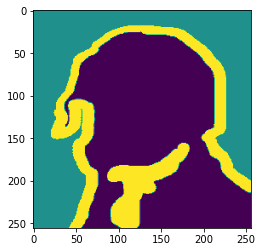

In [11]:
plt.imshow(img*100)

In [12]:
img.shape

(256, 256)

In [16]:
img[100]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=uint8)